In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf



plt.switch_backend('agg')
%matplotlib inline

In [2]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 15000
EMBEDDING_DIM = 200 # 100
VALIDATION_SPLIT = 0.2
LOAD_MODEL = True # True
EVALUATION_MODE = False
RUNS = 1
DROPOUT_RATE = 0.2

In [3]:
# reading data
import tensorflow_datasets as tfds

import sys

sys.path.append(r"myutils")

from myutils import clean_doc


import os

#import nltk

#nltk.download('stopwords')



In [4]:
#Load train dataset
DATASET ="imdb_reviews"  # 'yelp_polarity_reviews'
train = tfds.as_numpy(tfds.load(DATASET, data_dir=f"{DATASET}", split="train", batch_size=-1))
X_train, y_train = [clean_doc(x.decode()) for x in train["text"]], train["label"]

# Load test dataset
test = tfds.as_numpy(tfds.load(DATASET, data_dir=f"{DATASET}", split="test", batch_size=-1))
X_test, y_test = [clean_doc(x.decode()) for x in test["text"]], test["label"]

print(f"Train samples: {len(X_train)}")
print(f"Test samples:  {len(X_test)}")


Train samples: 25000
Test samples:  25000


In [5]:
print(X_train[0])

absolutely terrible movie lured christopher walken michael ironside great actors must simply worst role history even great acting could redeem movies ridiculous storyline movie early nineties us propaganda piece pathetic scenes columbian rebels making cases revolutions maria conchita alonso appeared phony pseudolove affair walken nothing pathetic emotional plug movie devoid real meaning disappointed movies like this ruining actors like christopher walkens good name could barely sit it


In [6]:
if LOAD_MODEL:
    with open('model/tokenizer_cnn.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
else:
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(X_train)

sequences = tokenizer.texts_to_sequences(X_train)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))


Number of Unique Tokens 121361


In [7]:
data1 = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels1 = to_categorical(np.asarray(y_train))

print('Shape of Data Tensor:', data1.shape)
print('Shape of Label Tensor:', labels1.shape)


Shape of Data Tensor: (25000, 1000)
Shape of Label Tensor: (25000, 2)


In [8]:
from myutils import create_glove_embeddings
emb_layer = create_glove_embeddings(
            embedding_dim  = EMBEDDING_DIM,
            max_num_words  = MAX_NB_WORDS,
            max_seq_length = MAX_SEQUENCE_LENGTH,
            tokenizer      = tokenizer
        )

Pretrained GloVe embedding is loading...
Found 400000 word vectors in GloVe embedding



In [9]:
if LOAD_MODEL:
    from keras.models import load_model

    model=load_model('model_cnn.h5')
    model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.SGD(),
              metrics=['acc'])
    model.summary()
else:
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = emb_layer(sequence_input)
    l_cov1= Conv1D(64, 3, activation='relu')(embedded_sequences)
    l_pool1 = MaxPooling1D(3)(l_cov1)
    #l_pool1 = Dropout(DROPOUT_RATE)(l_pool1)
    l_cov2 = Conv1D(64, 4, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(4)(l_cov2)
    #l_pool2 = Dropout(DROPOUT_RATE)(l_pool2)
    l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
    l_pool3 = MaxPooling1D(5)(l_cov3)
    
    l_cov4 = Conv1D(128, 5, activation='relu')(l_pool3)
    l_pool4 = MaxPooling1D(10)(l_cov4)  # global max pooling
    #l_pool3 = Dropout(DROPOUT_RATE)(l_pool3)
    
    l_flat = Flatten()(l_pool4)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')(l_dense)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.SGD(),
              metrics=['acc'])

    print("Simplified convolutional neural network")
    model.summary()
   

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 word_embedding (Embedding)  (None, 1000, 200)         3000000   
                                                                 
 conv1d (Conv1D)             (None, 998, 64)           38464     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 332, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 329, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 82, 64)           0         
 1D)                                                         

In [10]:
if not EVALUATION_MODE:
    for i in range(RUNS):
        print(f"Running iteration {i+1}/{RUNS}")
    
        indices = np.arange(data1.shape[0])
        np.random.shuffle(indices)
        data = data1[indices]
        labels = labels1[indices]
        nb_validation_samples = int(VALIDATION_SPLIT * data1.shape[0])

        x_train = data[:-nb_validation_samples]
        y_train = labels[:-nb_validation_samples]
        x_val = data[-nb_validation_samples:]
        y_val = labels[-nb_validation_samples:]
        
        cp=ModelCheckpoint(f"model_cnn.h5",monitor='val_loss',verbose=1,save_best_only=True, mode="min")
        earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=2,
                          verbose=1)
    
        history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=13, batch_size=50,callbacks=[cp, earlystop])

Running iteration 1/1
Epoch 1/8
400/400 [==============================] - ETA: 0s - loss: 0.6619 - acc: 0.5702
Epoch 1: val_loss improved from inf to 0.65584, saving model to model_cnn.h5
400/400 [==============================] - 48s 118ms/step - loss: 0.6619 - acc: 0.5702 - val_loss: 0.6558 - val_acc: 0.5706
Epoch 2/8
400/400 [==============================] - ETA: 0s - loss: 0.6541 - acc: 0.5726
Epoch 2: val_loss improved from 0.65584 to 0.65064, saving model to model_cnn.h5
400/400 [==============================] - 47s 118ms/step - loss: 0.6541 - acc: 0.5726 - val_loss: 0.6506 - val_acc: 0.5732
Epoch 3/8
400/400 [==============================] - ETA: 0s - loss: 0.6468 - acc: 0.5788
Epoch 3: val_loss improved from 0.65064 to 0.64670, saving model to model_cnn.h5
400/400 [==============================] - 46s 115ms/step - loss: 0.6468 - acc: 0.5788 - val_loss: 0.6467 - val_acc: 0.5752
Epoch 4/8
400/400 [==============================] - ETA: 0s - loss: 0.6416 - acc: 0.5842
Epoch 4

In [11]:
if not EVALUATION_MODE:
    with open('model/tokenizer_cnn.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("tokenizer has been saved.")

tokenizer has been saved.


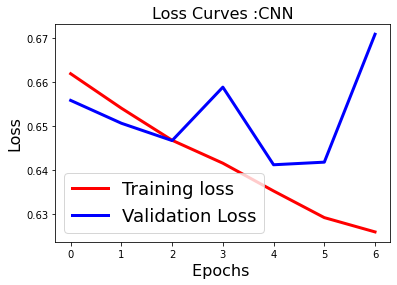

In [12]:
if not EVALUATION_MODE:
    fig1 = plt.figure()
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves :CNN',fontsize=16)
    fig1.savefig('loss_cnn.png')
    plt.show()

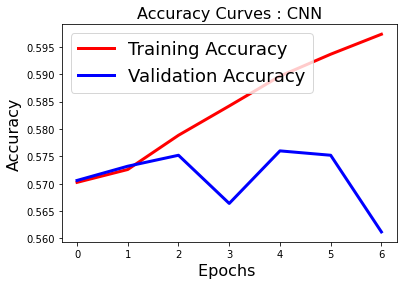

In [13]:
if not EVALUATION_MODE:
    fig2=plt.figure()
    plt.plot(history.history['acc'],'r',linewidth=3.0)
    plt.plot(history.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves : CNN',fontsize=16)
    fig2.savefig('accuracy_cnn.png')
    plt.show()

In [14]:
if not EVALUATION_MODE:
    from keras.utils.vis_utils import plot_model
    plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [15]:
if EVALUATION_MODE:
    from PIL import Image
    display(Image.open('cnn_model.png'))

In [16]:
from keras.models import load_model
# evaluation

with open('model/tokenizer_cnn.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

sequences_test = tokenizer.texts_to_sequences(X_test)
X_test_word    = pad_sequences(
    sequences_test,
    maxlen  = MAX_SEQUENCE_LENGTH,
    padding = 'post'
)

X_test_word = X_test_word



test_loss = []
test_accs = []


cnn_ = load_model(f"model_cnn.h5")
score = cnn_.evaluate(X_test_word, to_categorical(y_test), verbose=1)
test_loss.append(score[0])
test_accs.append(score[1])
    
print(f"\nLoss / accuracy on testset: {np.mean(test_loss)} loss / {np.mean(test_accs)} acc")
print(f"Standard deviation: (+-{np.std(test_loss)}) loss / (+-{np.std(test_accs)}) acc")

782/782 [==============================] - 14s 18ms/step - loss: 0.6390 - acc: 0.7247

Loss / accuracy on testset: 0.6389783024787903 loss / 0.7246800065040588 acc
Standard deviation: (+-0.0) loss / (+-0.0) acc


In [17]:
#from keras.utils.np_utils import to_categorical
#score = model.evaluate(X_test_word, to_categorical(y_test), verbose=1)